<a href="https://colab.research.google.com/github/DrLennon666/pytorch_experiments/blob/main/UTKFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Task Learning with PyTorch Lightning 

This notebook demonstrates multi-task learning on the [UTKFaces dataset](https://susanqq.github.io/UTKFace/). The datset is contains 99999999 image of cropped faces. Each image is of size 3x200x200. The image labels are contained in the file name which takes form `[age]_[gender]_[race]_[date&time].jpg`. 

- age: integer from 0 to 116 coresponding the age of the subject in the image.
- gender: integer representing the gender portrayed in the image. 0:male, 1:female
- race: integer from 0 to 4 representing the ethnicity of the subject of the photo. 0:white, 1:Black, 2:Asian, 3:Indian, 4:others
- date & time: date and time that the image was added to the dataset by UTK.

A `.csv` file containing the labels is also provided.


The EfficientNet-B0 architecture is imported from Torch Image Models `timm` and used as the encoder. The final fully connected layer of the standard EfficientNet model is replaced by 3 separate fully connected heads, one for each prediction task.

 `pytorch_lightning` is used to expedite experiment iterations. 

## Install `timm` and `pytorch_lightning`

The following cells are used to install the required packages that are not native to Colab.

In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 5.4 MB/s 


In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 829 kB 22.6 MB/s 
     |████████████████████████████████| 596 kB 35.3 MB/s 
     |████████████████████████████████| 132 kB 41.4 MB/s 
     |████████████████████████████████| 329 kB 45.4 MB/s 
     |████████████████████████████████| 1.1 MB 37.1 MB/s 
     |████████████████████████████████| 271 kB 41.0 MB/s 
     |████████████████████████████████| 192 kB 40.8 MB/s 
     |████████████████████████████████| 160 kB 48.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=68ee46970c6356204cb017961b80c8747070d2b2dc9681a67589a2e5e3ce9c42
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

## Import Packages

Import the required packages and dependencies.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.transforms import ToTensor, Compose, PILToTensor, ConvertImageDtype
#from torchvision.io import read_image
from pytorch_lightning.callbacks import ModelCheckpoint

import timm
import PIL
import pytorch_lightning as pl

## Downloade UTKFaces Dataset

The following cell clones a multi-task learning repo that built a TensorFlow model. For the purposes of this notebook the TF model can be ignored, we are solely interested in obtaining the UTKFaces data.

In [4]:
# Clone this repo to easily access the UTKFaces dataset. 
# Ignore the code in this repo.
!git clone https://github.com/ayulockin/faceattributes.git

Cloning into 'faceattributes'...
remote: Enumerating objects: 23407, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23407 (delta 4), reused 6 (delta 1), pack-reused 23388
Receiving objects: 100% (23407/23407), 115.73 MiB | 28.01 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (23747/23747), done.


In [ ]:
def display_random_faces(labels_df, image_path):
  '''
  Utility function to plot 16 random images from the UTKFaces dataset.
  
  inputs:
  labels_df (DataFrame) - DataFrame containing image names
  image_path (str) - Path to directory containing images.
  '''
  rand_image_idx = np.random.randint(0,labels_df.shape[0], size=16)

  fig, ax = plt.subplots(4,4, figsize=(10,10))
  for row in range(4):
    if row==0:
      temp_img_idx = rand_image_idx[0:4]
    elif row==1:
      temp_img_idx = rand_image_idx[4:8]
    elif row==2:
      temp_img_idx = rand_image_idx[8:12]
    elif row==3:
      temp_img_idx = rand_image_idx[12:]

    ax[row,0].imshow(PIL.Image.open(image_path+labels_df.image_id[temp_img_idx[0]]+'.jpg'))
    ax[row,1].imshow(PIL.Image.open(image_path+labels_df.image_id[temp_img_idx[1]]+'.jpg'))
    ax[row,2].imshow(PIL.Image.open(image_path+labels_df.image_id[temp_img_idx[2]]+'.jpg'))
    ax[row,3].imshow(PIL.Image.open(image_path+labels_df.image_id[temp_img_idx[3]]+'.jpg'))
  plt.tight_layout()
  plt.show()

In [5]:
csv_path = 'faceattributes/datasets/face_dataset.csv'
image_path = 'faceattributes/images/'
labels_df = pd.read_csv(csv_path)

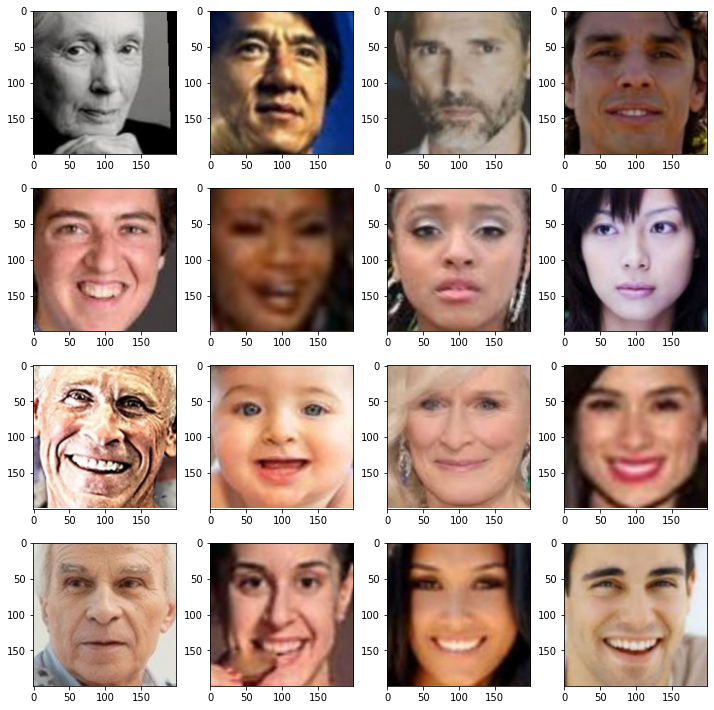

In [ ]:
display_random_faces(labels_df, image_path)

In [6]:
class UTKFaceDataset(Dataset):
  def __init__(self, labels_df, image_path, transform=None):
    self.image_path = image_path
    self.labels_df = labels_df
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, idx):
    img_path = self.image_path+self.labels_df.iloc[idx].image_id+'.jpg'
    image = PIL.Image.open(img_path)
    labels = (self.labels_df.iloc[idx].age, 
              self.labels_df.iloc[idx].gender,
              self.labels_df.iloc[idx].ethnicity)
    if self.transform:
      image = self.transform(image)
    return image, labels

In [ ]:
transforms = Compose([ToTensor(), 
         ConvertImageDtype(torch.float),
         ])

# utk_data = UTKFaceDataset(labels_df, image_path, transform=transforms)

# train_dataloader = torch.utils.data.DataLoader(utk_data, batch_size=64)
# val_loader = torch.utils.data.DataLoader(utk_data, batch_size=16)

In [11]:

# -----------------
# MODEL
# -----------------
class UTKFaceMultitaskClassifier(pl.LightningModule):

  def __init__(self):
    super(UTKFaceMultitaskClassifier, self).__init__()

    # UTKFace images are (3, 200, 200) (channels, width, height)
    model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=4)
    # Use Efficientnet_B0 and encoder, removing final FC layer
    self.encoder = nn.Sequential(*list(model.children())[:-1])
    self.fc_age = nn.Linear(in_features=1280, out_features=1, bias=True)
    self.fc_gender = nn.Linear(in_features=1280, out_features=2, bias=True)
    self.fc_ethnicity = nn.Linear(in_features=1280, out_features=5, bias=True)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.encoder(x)
    x_age = self.relu(self.fc_age(x))
    x_gender = self.fc_gender(x)
    x_ethnicity = self.fc_ethnicity(x)
    # Returns integer age value and integer corresponding to gender/ethnicity
    # This integer value is really the index of max value if we were generating
    # one hot vecors for targets
    return x_age, x_gender, x_ethnicity

  def combined_loss(self, logits, labels):
    '''
    Combining MSE and cross entropy loss functions.
    Age loss is weighted less than gender and ethnicity loss.
    '''
    age_loss = nn.MSELoss()
    gender_loss = nn.CrossEntropyLoss()
    ethnicity_loss = nn.CrossEntropyLoss()
    loss = torch.add(ethnicity_loss(logits[2],labels[2]), 
              torch.add(0.01*age_loss(logits[0].float(),labels[0].unsqueeze(1).float()), 
                        gender_loss(logits[1], labels[1])))

    #loss = torch.add(gender_loss(logits[1], labels[1]), 
    #                 ethnicity_loss(logits[2],labels[2]))
    
    return loss

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    logits = self.forward(x)
    loss = self.combined_loss(logits, y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    logits = self.forward(x)
    loss = self.combined_loss(logits, y)
    self.log('val_loss', loss)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [12]:
#-------------
# Data Module
#-------------

class UTKFaceDataModule(pl.LightningDataModule):

  def __init__(self, labels_df, image_path, batch_size, transforms=None):
    super().__init__()
    self.labels_df = labels_df
    self.image_path = image_path
    self.transforms=transforms
    self.batch_size = batch_size

  def setup(self, stage=None):
    data = UTKFaceDataset(self.labels_df, self.image_path, 
                          transform=self.transforms)
    num_train = int(self.labels_df.shape[0]*.95)
    num_valid = self.labels_df.shape[0]-num_train
    
    self.train_data, self.valid_data = random_split(data, [num_train, num_valid])


  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_data, batch_size=self.batch_size)

In [13]:
transforms = Compose([ToTensor(), 
         ConvertImageDtype(torch.float),
         ])

data_module = UTKFaceDataModule(labels_df, image_path, 64, transforms)

# train
model = UTKFaceMultitaskClassifier()

checkpoint_callback = ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(gpus=1, max_epochs=50, callbacks=[checkpoint_callback])

trainer.fit(model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Sequential | 4.0 M 
1 | fc_age       | Linear     | 1.3 K 
2 | fc_gender    | Linear     | 2.6 K 
3 | fc_ethnicity | Linear     | 6.4 K 
4 | relu         | ReLU       | 0     
--------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.071    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Load Model

In [ ]:
model_path =  '/content/epoch=1-step=703.ckpt'
#model=UTKFaceMultitaskClassifier()
model = UTKFaceMultitaskClassifier.load_from_checkpoint(model_path, hparams_file='/content/hparams.yaml')
model.eval()

UTKFaceMultitaskClassifier(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, t

## Inference

In [93]:
num_valid = 128
utk_module_valid = UTKFaceDataModule(labels_df, image_path, num_valid, transforms)
utk_module_valid.setup()
x, y = next(iter(utk_module_valid.val_dataloader()))

In [94]:
dev=torch.device("cuda") 
model.eval()

UTKFaceMultitaskClassifier(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, t

In [97]:
#x = x.to(dev)
preds=model.forward(x)

In [21]:
age_pred = preds[0].cpu().detach().numpy() #preds[0].detach().numpy()
gender_pred = np.argmax(preds[1].cpu().detach().numpy(), axis=1)
ethnicity_pred = np.argmax(preds[2].cpu().detach().numpy(), axis=1)

In [47]:
num_gender_correct = 0
num_ethnicity_correct = 0
for i in range(len(gender_pred)):
  if gender_pred[i]==y[1].detach().cpu()[i].item():
    num_gender_correct += 1

for i in range(len(ethnicity_pred)):
  if ethnicity_pred[i]==y[2].detach().cpu()[i].item():
    num_ethnicity_correct += 1

print(f'Gender Accuracy: {num_gender_correct/len(gender_pred)}')
print(f'Ethnicity Accuracy: {num_ethnicity_correct/len(ethnicity_pred)}')

Gender Accuracy: 0.9765625
Ethnicity Accuracy: 0.9140625


In [73]:
age_true = y[0].detach().cpu().numpy()
age_mse = np.square(age_pred.reshape(-1)-age_true).mean()
print(f'Age Predeiction MSE: {age_mse}')

Age Predeiction MSE: 39.14764069720861
